In [191]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)


Toggle code

# Get campaign/comment and kol data 

In [192]:
#-*- coding:utf-8 -*-  
import time
import datetime
import openpyxl
from collections import OrderedDict
import pandas as pd
import os
import logging
from IPython.display import display
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter('ignore')

#dir=os.path.dirname(os.path.realpath(__file__))+"/temp_files/untrackable_perf/"
dir =r"../data/"
df_campaign=pd.DataFrame()
df_comment=pd.DataFrame()
df_kol=pd.DataFrame()
df_data_capturing=pd.DataFrame()
Brand_map = OrderedDict([('Tissot',['天梭','tissot']),
                            ("Fiyta",["飞亚达",'fiyta']),
                            ("Casio",["卡西欧",'casio']),
                            ("Longines",["浪琴",'longines'])
                            ])

def data_save_to_csv(df,filename):
    print('Saving '+filename + ".csv")
    df.to_csv(path_or_buf=dir+filename+".csv",index=False,encoding='utf_8_sig',mode='w')
    
def get_capturing_data(file_path,file_name):
    print(file_path)
    workbook = pd.ExcelFile(file_path)
    sheetnames = workbook.sheet_names 
    sheetnames = [sheetname for sheetname in sheetnames if '文档主题' in  sheetname]
    colnames=['id',"Type",'ReleaseDate','ReleaseTime','Author','MediaType','Website','Title','Content','Url','EmotionTag','Visits','Comments','Forwords','Likes','HeatIndex']
    data=pd.read_excel(io=file_path,sheet_name =sheetnames ,usecols = "A:P",names=colnames) 
    values=pd.DataFrame()
    for key,value in data.items():
        Brand= key.split("-")[1]        
        b_cols = [b_col for b_col,a_cols in Brand_map.items() if Brand.lower() in [a_col.lower().replace(" ","") for a_col in a_cols]]
        if len(b_cols)>0:
            Brand= b_cols[0] 
        value["Brand"]=Brand
        if len(value)>0:
            values=values.append(value)
    if len(values)>0:
        global df_data_capturing
        df_data_capturing=values.reset_index(drop=True)


def get_data_from_files(file_path,file_name):
    if 'campaign' in file_name.lower():
        global df_campaign
        df_campaign=get_campaign_data(file_path,file_name)
        
    
    if 'comment' in file_name.lower():
        global df_comment
        df_comment=get_comment_data(file_path,file_name)
        
    if 'kol' in file_name.lower():
        global df_kol
        df_kol=get_kol_data(file_path,file_name)
    
        
def get_campaign_data(file_path,file_name):
    col_name_map = OrderedDict([('id',['id']),
                                ("Type",["类型"]),
                                ('ReleaseDate',['发布日期']),
                                ('ReleaseTime',["发布时间"]),
                                ('Author',["作者"]),
                                #('IsKOL',["是否KOL"]),
                                ('MediaType',["媒体类型"]),
                                ('Website',["来源网站"]),
                                ('Title',["标题"]),
                                ('Content',["内容"]),
                                ('Url',["url"]),
                                ('Visits',["访问数"]),
                                ('Comments',["回复/评论数"]),
                                ('Forwords',["转发数"]),
                                ('Likes',["点赞数"]),
                                ('Influence',["影响力"])
                                ])
    return get_cell_data(col_name_map,file_path,file_name,'campaign')
    
def get_comment_data(file_path,file_name):
    col_name_map = OrderedDict([('Brand',['品牌']),
                                ("EmotionTag",["情感极性"]),
                                ("Content",["评论"]),
                                ('Date',['日期']),
                                ('Time',["时间"]),
                                ('Plantform',["平台"]),
                                ('Url',["url","商品URL"])
                                ])
    return get_cell_data(col_name_map,file_path,file_name,'comment')

def get_kol_data(file_path,file_name):
    col_name_map = OrderedDict([('id',['id']),
                                ("Metaname",["metaname"]),
                                ("kolAccount",["kol账号名称"]),
                                ("Source",["来源榜单"]),
                                ("ActiveFans",["活跃粉丝数"]),
                                ('Influence',["影响力"]),
                                ('Title',["标题"]),
                                ('Url',["url","商品URL"]),
                                ('ReleaseDate',['发布日期']),
                                ('ReleaseTime',["发布时间"]),
                                ('Content',["正文"]),
                                ('Read',["阅读数"]),
                                ('Likes',["点赞数"]),
                                ('HeatIndex',["热度值"])
                                ])
    return get_cell_data(col_name_map,file_path,file_name,'kol')

    
def get_cell_data(col_name_map,file_path,file_name,tag):
    print(file_path)
    column_names=list(col_name_map.keys())
    workbook = openpyxl.load_workbook(filename=file_path)
    worksheets = workbook.sheetnames   # get all sheetnames
    
    df_all=pd.DataFrame()
    for worksheetname in worksheets:
        if "汇总" in worksheetname.lower() or "分析" in worksheetname.lower():
            continue
        worksheet = workbook[worksheetname]
        rows = worksheet.max_row #get max row number of worksheet
        columns = worksheet.max_column  #get max column number of worksheet
        
        #column name,with mapping index
        colidxmap={}
        df=pd.DataFrame()
        for i in range(1,columns+1):
            colval_ =  worksheet.cell(row=1, column=i).value
            colname_ = repr(colval_).replace("_","").replace("\\r"," ").replace(".","").replace("\\n","").replace(" ","").strip("'")
            b_cols = [b_col for b_col,a_cols in col_name_map.items() if colname_.lower() in [a_col.lower().replace(" ","") for a_col in a_cols]]
            if len(b_cols) > 0:
                colidxmap[b_cols[0]] = i

        #data for each row
        all_content = []
        for row in range(2,rows+1):
            row_content = []
            for column_name in column_names:
                if column_name in colidxmap.keys():
                    cell_content= worksheet.cell(row,int(colidxmap[column_name])).value
                else:
                    cell_content=None
                    if row==2: #only print 1 time
                        print("Column %s is not found in file %s"%(column_name,file_name))
                if len(str(cell_content))> 300 and cell_content!=None:
                      cell_content=cell_content[:300] 
                if column_name in ('Content',"Author",'Title') and cell_content!=None:
                      cell_content=str(cell_content).replace("\r","").replace("\n","")
                row_content.append(cell_content)
            #print(row_content)
            all_content.append(row_content)
        
        df=pd.DataFrame(all_content,columns=column_names)
        if len(df)>0:
            df.insert(0,tag,worksheetname)
            df_all=pd.concat([df_all,df])
    return df_all

def main(): 
    _st = time.time()
    now = datetime.datetime.now()
    print(str(now))
    print('Begin reading ...')
    try:
        for root, dirs, files in os.walk(dir):
            for fn in files:
                if fn.startswith("~$") or os.path.splitext(fn)[1] not in [".xlsx",".xlsm","xls"]:
                    continue
                file_name = os.path.splitext(fn)[0]
                file_path = os.path.join(root,fn)
                #print(file_name+'  :   '+file_path)
                if os.path.isfile(file_path):
                    if 'capturing' in file_name.lower():
                        get_capturing_data(file_path,file_name)
                    else:
                        get_data_from_files(file_path,file_name)
        print('Reading data totally took %s seconds.'%(time.time() - _st))
    except Exception as v:
        traceback.print_exc()
        sys.exit(1)


if __name__ == '__main__':
    logging.basicConfig(format='[%(asctime)s][%(levelname)s]:%(message)s',level=logging.INFO)
    main()

2018-04-03 18:18:49.565558
Begin reading ...
../data/Tissot KiSS_Data campaign20180301-20180331.xlsx
../data/Tissot KiSS_Data Capturing_20180301_2018....xlsx
../data/Tissot KiSS_Data comment20180301-20180331.xlsx
../data/Tissot KiSS_Data kol20180301-20180331.xlsx
Reading data totally took 36.06529235839844 seconds.


In [193]:
#from matplotlib import font_manager
#fontP = font_manager.FontProperties()
#fontP.set_family('SimHei')
#fontP.set_size(14)
import matplotlib
#matplotlib.rcParams['font.sans-serif']=['SimHei']
matplotlib.rcParams['font.family']=['SimHei']
matplotlib.rcParams['font.size']=12
#matplotlib.rcParams["lines.marker"] = “o”


title_fsize = 18
font_size =15
#brand_colors  = ['blue', 'darkorange', 'grey', 'yellow']

brand_index = ['Tissot', 'Fiyta', 'Casio', 'Longines']
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 500)

def RGBInt2Float(Color_List):
    Brand_colors=[]
    for color in Color_List:
        col=[x / 255.0 for x in color]
        col=tuple(col)
        Brand_colors.append(col)
    return Brand_colors
Color_List = [(0,112,192),(237,125,49),(165,165,165),(255,192,0)]
brand_colors=RGBInt2Float(Color_List)

## 1.Display Campaign data

In [207]:
df_camp_brand=pd.DataFrame(columns=['campaign','Brand'])
i=0
for camp in df_campaign['campaign'].unique():
    Brand='Others'
    Brand_map = OrderedDict([('Tissot',['天梭','tissot']),
                            ("Fiyta",["飞亚达",'fiyta']),
                            ("Casio",["卡西欧",'casio']),
                            ("Longines",["浪琴",'longines'])
                             ])
    b_cols = [b_col for b_col,a_cols in Brand_map.items() if [a_col.lower().replace(" ","") for a_col in a_cols if a_col.lower() in camp.lower()]]
    if len(b_cols)>0:
        Brand=b_cols[0]
    df_camp_brand.loc[i]=[camp,Brand]
    i=i+1
df_campaign_b=pd.merge(df_campaign,df_camp_brand,how='left',left_on='campaign',right_on='campaign')

df_campaign_b[['Visits','Comments','Forwords','Likes','Influence']]=df_campaign_b[['Visits','Comments','Forwords','Likes','Influence']].astype(int)


df_camp=df_campaign_b[(   
                        (df_campaign_b['Type']== "常规" )  
                      & (   (  ( df_campaign_b['ReleaseDate'] >='2018-03-20')  &  (df_campaign_b['Brand'] != 'Others' ) )
                           |(df_campaign_b['Brand'] == 'Others')
                        )
                      & ( ~df_campaign_b['MediaType'].isin(['新闻','APP','视频'])   )
                    )] 
df_camp_inf=df_camp.groupby(['campaign','ReleaseDate'])['Influence'].sum().reset_index().rename(columns={'Influence':'TotalInfluence'})
df_camp_cnt=df_camp.groupby(['campaign','ReleaseDate'])['id'].count().reset_index().rename(columns={'id':'Buzz'})
df_camp_result =pd.merge(df_camp_inf, df_camp_cnt)
df_camp_pt=pd.pivot_table(df_camp_result, index=['ReleaseDate'],columns=['campaign'],values=['TotalInfluence','Buzz'])
df_camp_pt[df_camp_pt.columns]=df_camp_pt[df_camp_pt.columns].fillna(0).astype(int)
display(list(df_camp.MediaType.unique()))
display(df_camp_pt)


['微信', '微博', '论坛']

Buzz                                         \
campaign    Women’s Day 第46届巴塞尔世界钟表珠宝展（卡西欧） 第46届巴塞尔世界钟表珠宝展（天梭）   
ReleaseDate                                                      
2018-03-05            5                   0                  0   
2018-03-06           14                   0                  0   
2018-03-07            9                   0                  0   
2018-03-08           20                   0                  0   
2018-03-09            3                   0                  0   
2018-03-10            2                   0                  0   
2018-03-11            3                   0                  0   
2018-03-20            0                   0                  7   
2018-03-21            0                   0                  6   
2018-03-22            0                   1                 63   
2018-03-23            0                   1                 70   
2018-03-24            0                   0                 16   
2018-03-25            0                   1                  9   
2018-03-26            0                   1                 21   
2018-03-27            0                   0                 10   
2018-03-28            0                   0                 12   
2018-03-29            0                   0                 12   
2018-03-30            0                   2                 12   
2018-03-31            0                   0                  1   

                                                   TotalInfluence  \
campaign    第46届巴塞尔世界钟表珠宝展（浪琴） 第46届巴塞尔世界钟表珠宝展（飞亚达）    Women’s Day   
ReleaseDate                                                         
2018-03-05                   0                   0            303   
2018-03-06                   0                   0            942   
2018-03-07                   0                   0            438   
2018-03-08                   0                   0            921   
2018-03-09                   0                   0            189   
2018-03-10                   0                   0            120   
2018-03-11                   0                   0            185   
2018-03-20                   5                   0              0   
2018-03-21                   6                   0              0   
2018-03-22                   5                   1              0   
2018-03-23                  14                   2              0   
2018-03-24                  12                   4              0   
2018-03-25                  16                   2              0   
2018-03-26                  12                   3              0   
2018-03-27                   8                   3              0   
2018-03-28                  10                   6              0   
2018-03-29                  16                   8              0   
2018-03-30                   4                   6              0   
2018-03-31                   1                   0              0   

                                                                       \
campaign    第46届巴塞尔世界钟表珠宝展（卡西欧） 第46届巴塞尔世界钟表珠宝展（天梭） 第46届巴塞尔世界钟表珠宝展（浪琴）   
ReleaseDate                                                             
2018-03-05                    0                  0                  0   
2018-03-06                    0                  0                  0   
2018-03-07                    0                  0                  0   
2018-03-08                    0                  0                  0   
2018-03-09                    0                  0                  0   
2018-03-10                    0                  0                  0   
2018-03-11                    0                  0                  0   
2018-03-20                    0                511                332   
2018-03-21                    0                214                300   
2018-03-22                   74               2230                264   
2018-03-23                   81               2482                738   
2018-03-24               

['新闻', 'APP', '视频']

%              
InfTag     0~20  21~49    50~
Brand                        
Tissot    50.76  34.97  14.26
Fiyta     42.29  26.37  31.34
Casio     68.10  25.00   6.90
Longines  54.32  24.69  20.99

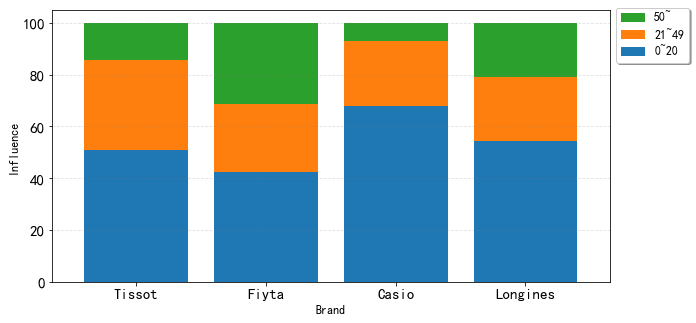

In [209]:
df_camp_other=df_campaign_b[(   
                        (df_campaign_b['Type']== "常规" )  
                      & (   (  ( df_campaign_b['ReleaseDate'] >='2018-03-20')  &  (df_campaign_b['Brand'] != 'Others' ) )
                           |(df_campaign_b['Brand'] == 'Others')
                        )
                      & ( df_campaign_b['MediaType'].isin(['新闻','APP','视频'])   )
                    )]
display(list(df_camp_other.MediaType.unique()))
df_camp_other['InfTag'] =pd.cut(df_camp_other.Influence, [0, 20, 49,100000000])
df_camp2=df_camp_other.loc[:,['campaign','Brand','Influence','InfTag']]
df_camp22=df_camp2.groupby(['campaign','Brand','InfTag'])['Influence'].count().reset_index().rename(columns={'Influence':'Count'})
df_camp33=df_camp2.groupby(['campaign','Brand'])['Influence'].count().reset_index().rename(columns={'Influence':'TotalCount'})
df_camp44= pd.merge(df_camp22,df_camp33,how='left', on=['campaign','Brand'])
df_camp44["%"]=round(df_camp44['Count']*100/df_camp44['TotalCount'],2)
df_camp44['InfTag']=df_camp44['InfTag'].astype(str)
df_camp44['InfTag']= df_camp44.InfTag.replace('(49, 100000000]',"50~").replace("(0, 20]","0~20").replace("(20, 49]","21~49")
df_camp_cut=df_camp44.loc[:,['Brand','InfTag',"%"]]
df_camp_cut=df_camp_cut[(df_camp_cut['Brand']!='Others')].reset_index(drop=True)
df_camp_cut_pt=pd.pivot_table(df_camp_cut, index=['Brand'],columns=['InfTag'],values=["%"])
df_camp_cut_pt=df_camp_cut_pt.reindex(brand_index)
display(df_camp_cut_pt)
axx=df_camp_cut_pt.plot(kind='bar',stacked=True,y="%",legend=False,grid=False,width=0.8,figsize=(10,5),fontsize=font_size)
axx.yaxis.grid( linestyle='--', which='major',color='grey', alpha=.25)
axx.set_ylabel("Influence")
plt.xticks(rotation=360);
#plt.legend(shadow=True,loc='best')
#axx.set_title("Top 15 kol Influence of each Brand",fontsize=title_fsize)
handles, labels = axx.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],shadow=True, bbox_to_anchor=(1,1.03));

## 1.1 Influence/Buzz Comparision for each Campaign

In [196]:

cmap_brand_ix=[ brand_index.index(Brand) for Brand in df_camp_brand.Brand if Brand in brand_index]
cmap_brand_ix.sort()
cmap_brand_index= [brand_index[ix]  for ix in cmap_brand_ix]
cmap_brand_colors= [brand_colors[ix]  for ix in cmap_brand_ix]
cmap_index = [ df_camp_brand[df_camp_brand['Brand']==brand]['campaign'].tolist()[0] for brand in cmap_brand_index ]

cmap_index2=cmap_index.copy()
Others_Camp=[]
for ix in df_camp_brand[df_camp_brand['Brand']=='Others'].index:
    Ocamp=df_camp_brand.loc[ix,'campaign']
    cmap_index2.append(Ocamp)
    Others_Camp.append(Ocamp)


['微信', '微博', '论坛']

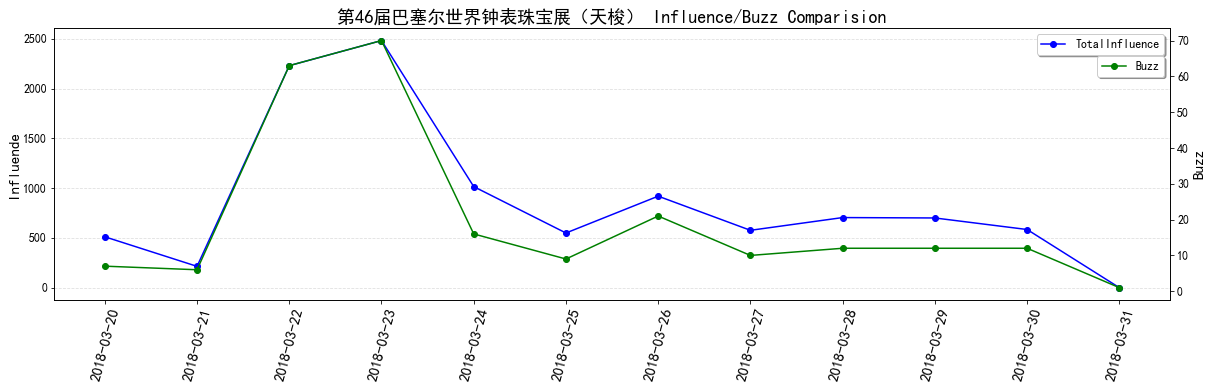

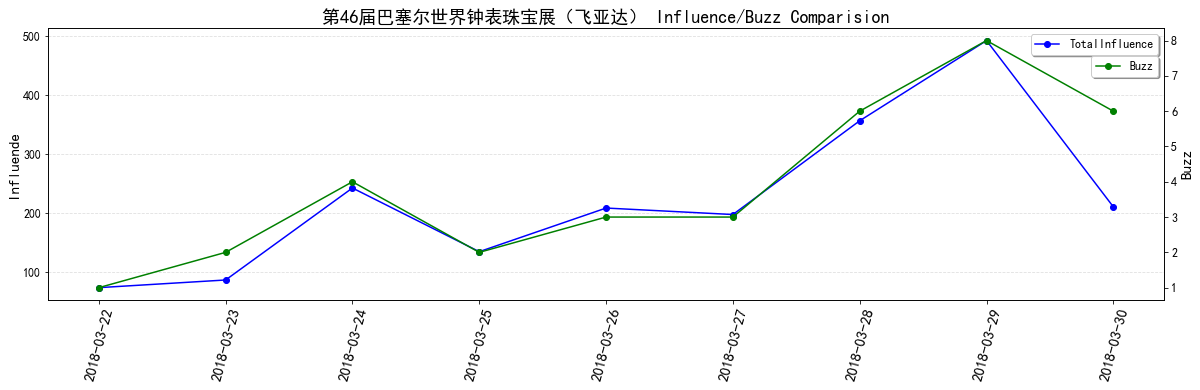

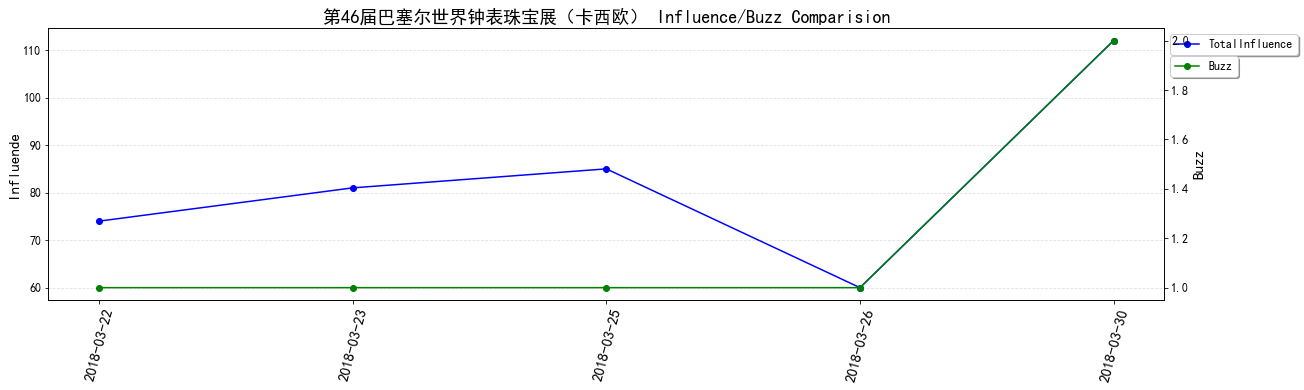

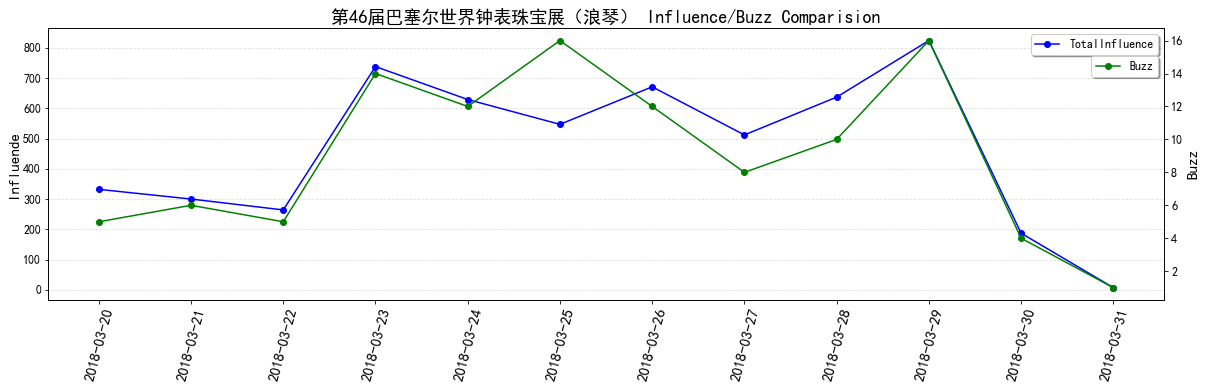

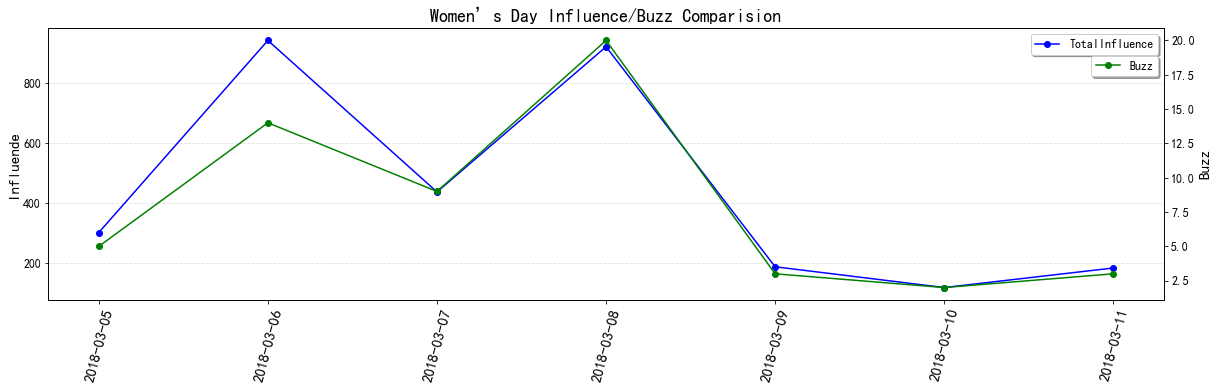

In [210]:
display(list(df_camp.MediaType.unique()))
for camp in cmap_index2:
        df_camp_each=df_camp_result[ (df_camp_result['campaign']==camp)].reset_index(drop=True)
        df_camp_each=df_camp_each.fillna(0)
        #df_camp_plot=df_camp_each.plot(kind="line",  x='ReleaseDate', y=['TotalInfluence','Buzz'],#secondary_y=True,    
                              #marker='o', grid=False,figsize=(20,5),fontsize=font_size,use_index=False)
        fig, ax = plt.subplots()
        ax2 = ax.twinx()
        df_camp_each.TotalInfluence.plot(ax=ax,color='b',marker='o',figsize=(20,5))
        df_camp_each.Buzz.plot(ax=ax2, color='g',marker='o')
        ax.set_xticks(df_camp_each.index)
        ax.set_xticklabels(df_camp_each['ReleaseDate'],rotation=75,fontsize=font_size)
        ax.set_title(camp+" Influence/Buzz Comparision",fontsize=title_fsize)
        ax.set_ylabel('Influende', color='black',fontsize=font_size)
        ax2.set_ylabel('Buzz', color='black',fontsize=font_size)
        ax.yaxis.grid( linestyle='--', which='major',color='grey', alpha=.25)
        #ax.legend(shadow=True, loc='best')
        #ax2.legend(shadow=True, loc='right')
        ax.legend(shadow=True, bbox_to_anchor=(1.0, 1.0))
        ax2.legend(shadow=True, bbox_to_anchor=(1.0, 0.92))
        '''for i in df_camp_each.index:
                plt.text( x=i, y= df_camp_each.loc[i,'TotalInfluence'],s=str( int(df_camp_each.loc[i,'TotalInfluence'])),color="black",verticalalignment="baseline", horizontalalignment="center", size=10) 
                plt.text( x=i, y= df_camp_each.loc[i,'Buzz'],s=str( int(df_camp_each.loc[i,'Buzz'])),color="black",verticalalignment="baseline", horizontalalignment="center", size=10) 
                '''
        #fig.show()


## 1.2 Campaign Influence Comparision and Campaign Buzz Comparision

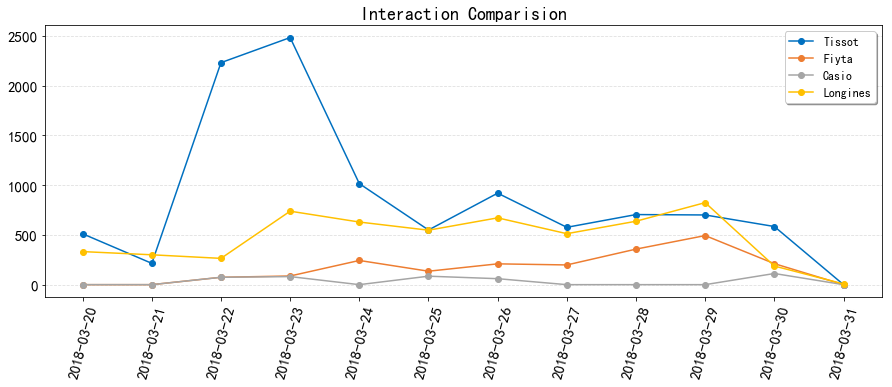

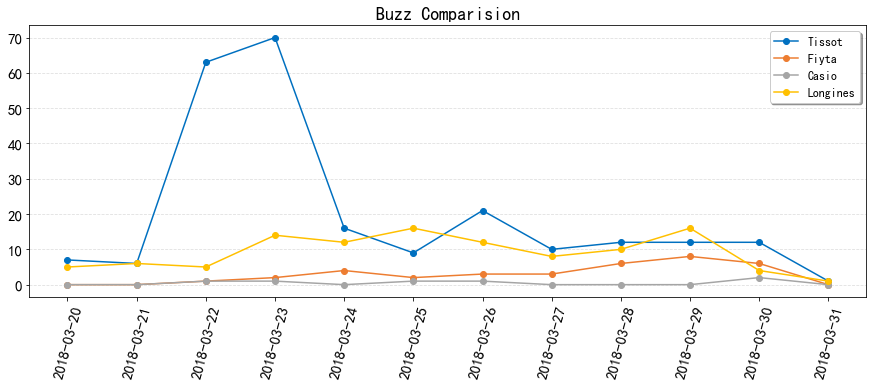

In [198]:
df_camp_inf2=df_camp.groupby(['Brand','ReleaseDate'])['Influence'].sum().reset_index().rename(columns={'Influence':'TotalInfluence'})
df_camp_cnt2=df_camp.groupby(['Brand','ReleaseDate'])['id'].count().reset_index().rename(columns={'id':'Buzz'})
df_camp_result2 =pd.merge(df_camp_inf2, df_camp_cnt2)
df_camp_result2=df_camp_result2[ df_camp_result2['Brand']!='Others' ]
for measurevalue in ['TotalInfluence','Buzz']:
        df_camp_pt2=pd.pivot_table(df_camp_result2, index=['ReleaseDate'],columns=['Brand'],values=[measurevalue])

        new_columns_name= list( df_camp_pt2.columns.levels[1] )

        df_camp_pt2.columns = new_columns_name
        df_camp_pt2=df_camp_pt2.fillna(0)
        df_camp_pt2[new_columns_name]=df_camp_pt2[new_columns_name].astype(int)
        df_camp_pt2=df_camp_pt2.reindex(columns=brand_index) #sort campaign by brand
        df_camp_pt2=df_camp_pt2.reset_index()

        df_camp_plot=df_camp_pt2.plot(kind="line",x='ReleaseDate',  marker='o',                 
                                 #subplots =False,sharex=False,sharey=False, layout =(1,2),logx =True,stacked =True,marker='o',table=False,
                                    color =  cmap_brand_colors,
                                  legend=True,grid=False,figsize=(15,5),fontsize=font_size,use_index=False)
        title='Buzz'
        if measurevalue=='TotalInfluence':
            title='Interaction'
        df_camp_plot.set_title( title+" Comparision",fontsize=title_fsize)
        df_camp_plot.set_xticks(df_camp_pt2.index)
        df_camp_plot.set_xticklabels(df_camp_pt2['ReleaseDate'],rotation=75,fontsize=font_size)
        df_camp_plot.yaxis.grid( linestyle='--', which='major',color='grey', alpha=.25)
        plt.legend(shadow=True,loc='best')


## 2.Porcess and Display comment data

In [199]:
df_comment=df_comment.reset_index(drop=True)
df_comment['Brand']=df_comment['Brand'].str.title()
kw_list=['老婆','老公','家人','女朋友','男朋友','礼物','第一块','情人节','弟弟,儿子']

#keywords count
df_com_kw = pd.DataFrame()
for kws in kw_list:
    i=0
    df_kw = pd.DataFrame()
    kw=kws.replace(',','|')
    df_kw=  df_comment[ df_comment.Content.str.contains(kw,na=False) ]
    df_kw=df_kw.groupby(['Brand','Plantform'])['Content'].count().reset_index().rename(columns={'Content':'Count'})
    
    df_kw['Keywords']=kws
    df_com_kw=df_com_kw.append(df_kw)

#1.Others
kw_str= (",".join(str(kw) for kw in kw_list)  ).replace(',','|')
df_kw2= df_comment[ ~df_comment.Content.str.contains(kw_str,na=False) ]
df_kw2= df_kw2.groupby(['Brand','Plantform'])['Content'].count().reset_index().rename(columns={'Content':'Count'})
df_kw2['Keywords']='Others'
df_com_kw=df_com_kw.append(df_kw2)
df_com_kw=df_com_kw.reset_index(drop=True)
#2.Append Total count( row)
df_com_total= df_comment.groupby(['Brand','Plantform'])['Date'].count().reset_index().rename(columns={'Date':'Count'})
df_com_total['Keywords']='Grand Total'
df_com_kw_result=df_com_kw.append(df_com_total)
#3.Calculate percentages (columns)
df_com_total2= df_com_total.copy().rename(columns={'Keywords':'GT KW','Count':'TotalCount'  })
df_com_kw_result = pd.merge(df_com_kw_result, df_com_total2, how='left', on=['Brand','Plantform']) 
df_com_kw_result['Weighted Percentages']=(df_com_kw_result['Count']/df_com_kw_result['TotalCount']*100).round(2)

#4.pivot data and display result
df_com_pt=pd.pivot_table(df_com_kw_result, index=['Keywords'],columns=['Brand','Plantform'],values=['Count','Weighted Percentages'])
df_com_pt=df_com_pt.fillna(0)
kw_list_sort=kw_list
kw_list_sort.append('Others')
kw_list_sort.append('Grand Total')
df_com_pt=df_com_pt.reindex(kw_list_sort)
display(df_com_pt)

Count                                     Weighted Percentages  \
Brand         Casio         Fiyta       Longines                       Casio   
Plantform    taobao  tmall taobao tmall   taobao  tmall               taobao   
Keywords                                                                       
老婆              5.0    0.0    0.0   0.0     12.0    4.0                 0.20   
老公             13.0    3.0    0.0   6.0     47.0    6.0                 0.53   
家人             11.0    0.0    0.0   0.0      7.0    0.0                 0.45   
女朋友            23.0    0.0    2.0   0.0      1.0    1.0                 0.94   
男朋友            86.0    3.0    0.0   0.0     10.0    1.0                 3.51   
礼物             42.0    3.0    2.0   3.0     20.0    5.0                 1.71   
第一块             3.0    2.0    0.0   0.0      0.0    0.0                 0.12   
情人节             0.0    0.0    0.0   0.0      1.0    1.0                 0.00   
弟弟,儿子          29.0    2.0    0.0   0.0      7.0    1.0                 1.18   
Others       2266.0  235.0   85.0  43.0    579.0  126.0                92.38   
Grand Total  2453.0  248.0   89.0  49.0    673.0  143.0               100.00   

                                                      
Brand                 Fiyta         Longines          
Plantform     tmall  taobao   tmall   taobao   tmall  
Keywords                                              
老婆             0.00    0.00    0.00     1.78    2.80  
老公             1.21    0.00   12.24     6.98    4.20  
家人             0.00    0.00    0.00     1.04    0.00  
女朋友            0.00    2.25    0.00     0.15    0.70  
男朋友            1.21    0.00    0.00     1.49    0.70  
礼物             1.21    2.25    6.12     2.97    3.50  
第一块            0.81    0.00    0.00     0.00    0.00  
情人节            0.00    0.00    0.00     0.15    0.70  
弟弟,儿子          0.81    0.00    0.00     1.04    0.70  
Others        94.76   95.51   87.76    86.03   88.11  
Grand Total  100.00  100.00  100.00   100.00  100.00

## 3. KOL

,Influence
Brand,
Tissot,638540
Fiyta,393186
Casio,761912
Longines,809270


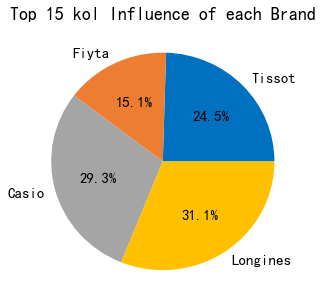

In [200]:
n=15
df_kol=df_kol.dropna()
df_kol[['Influence']]=df_kol[['Influence']].astype(int)
df_kol_topN=df_kol.groupby('kol')['Influence'].nlargest(n).reset_index()
df_kol_topN=df_kol_topN.groupby('kol')['Influence'].sum().reset_index()
df_kol_topN['Brand']=df_kol_topN['kol'].str.split(pat="20").str[0].str.title()
df_kol_topN=df_kol_topN.drop(['kol'], axis=1)
df_kol_topN=df_kol_topN.set_index('Brand')
df_kol_topN=df_kol_topN.reindex(brand_index)
display(df_kol_topN)

df_kol_topN_plot=df_kol_topN.plot(kind="pie",y='Influence',
                          colors  = brand_colors,                           
                          legend=False,figsize=(5,5),fontsize=font_size,use_index =False,autopct='%.1f%%')
df_kol_topN_plot.set_ylabel('')
df_kol_topN_plot.set_title("Top 15 kol Influence of each Brand",fontsize=title_fsize);


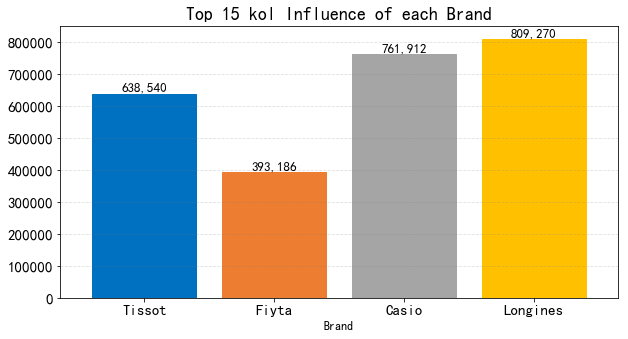

In [201]:
df_kol_topN_plot = df_kol_topN.plot(kind="bar",width=0.8,
                                    legend=False,grid=False,figsize=(10,5),fontsize=font_size,use_index =True)
df_kol_topN_plot.set_title("Top 15 kol Influence of each Brand",fontsize=title_fsize)
df_kol_topN_plot.yaxis.grid( linestyle='--', which='major',color='grey', alpha=.25)
i=0
for rect in df_kol_topN_plot.patches:
    height = rect.get_height()
    rect.set_color(brand_colors[i])
    label = '{:,.0f}'.format(height)
    df_kol_topN_plot.text(rect.get_x() + rect.get_width() / 2, height + 5, label,color='black',
            ha='center', va='bottom',weight='light',clip_on=True, fontsize= font_size-2)
    i=i+1
plt.xticks(rotation=360);

## 4.Capturing 

Brand,Tissot,Fiyta,Casio,Longines
MediaType,,,,
视频,10,2,1,21
论坛,76,14,49,131
APP,152,73,92,186
微信,355,181,238,709
微博,1289,115,398,407
新闻,2018,1277,3395,2069


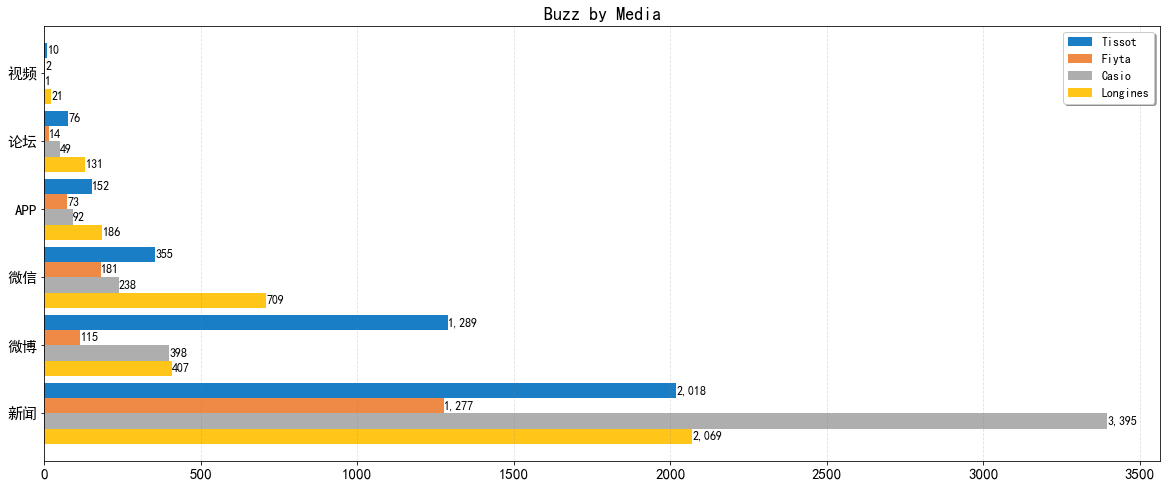

In [202]:
df_brand_mediatype_buzz=df_data_capturing[df_data_capturing['Type']=='常规'].groupby(['Brand','MediaType'])['id'].count().reset_index().rename(columns={'id':'Buzz'})
df_brand_mediatype_buzz_pt=pd.pivot_table(df_brand_mediatype_buzz, index=['MediaType'],columns=['Brand'],values=['Buzz'])
df_brand_mediatype_buzz_pt=df_brand_mediatype_buzz_pt.fillna(0)
df_brand_mediatype_buzz_pt.columns = df_brand_mediatype_buzz_pt.columns.levels[1]
mediatype_index=['视频','论坛','APP','微信','微博','新闻']
df_brand_mediatype_buzz_pt=df_brand_mediatype_buzz_pt.reindex(index=mediatype_index,columns=brand_index)
display(df_brand_mediatype_buzz_pt)
df_brand_mediatype_buzz_pt=df_brand_mediatype_buzz_pt.reindex(index=mediatype_index[::-1],columns=brand_index[::-1])
df_brand_mediatype_buzz_plot = df_brand_mediatype_buzz_pt.plot(kind="barh",
                                                               color=brand_colors[::-1],
                                                               alpha=.9, width=.9,figsize=(20,8),fontsize=font_size,use_index =True)
df_brand_mediatype_buzz_plot.set_title("Buzz by Media",fontsize=title_fsize)
df_brand_mediatype_buzz_plot.set_ylabel('')
df_brand_mediatype_buzz_plot.set_yticklabels(df_brand_mediatype_buzz_pt.index)
df_brand_mediatype_buzz_plot.xaxis.grid( linestyle='--', which='major',color='grey', alpha=.25)
handles, labels = df_brand_mediatype_buzz_plot.get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1],shadow=True, loc='best');

for rect in df_brand_mediatype_buzz_plot.patches:
        width = rect.get_width()
        rankStr = '{:,.0f}'.format(width)
        # Shift the text to the left side of the right edge
        xloc = width + 1
        clr = 'black'
        align = 'left'
        verticalalignment = 'center'

        # Center the text vertically in the bar
        yloc = rect.get_y() + rect.get_height()/2.0
        label = df_brand_mediatype_buzz_plot.text(xloc, yloc, rankStr, horizontalalignment=align,
                         verticalalignment='center', color=clr, weight='light',
                         clip_on=True);


,Buzz
Brand,
Tissot,3900
Fiyta,1662
Casio,4173
Longines,3523


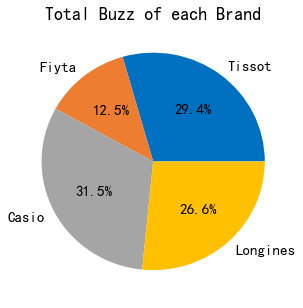

In [203]:
df_brand_buzz=df_data_capturing[df_data_capturing['Type']=='常规'].groupby(['Brand','ReleaseDate'])['id'].count().reset_index().rename(columns={'id':'Buzz'})
df_brand_buzz_pie=df_brand_buzz.groupby('Brand')['Buzz'].sum().reindex(brand_index);
display(df_brand_buzz_pie.to_frame())
df_brand_buzz_plot=df_brand_buzz_pie.plot(kind="pie",colors=brand_colors,
                          legend=False,grid=True,figsize=(5,5),fontsize=font_size,use_index =True,autopct='%.1f%%')

df_brand_buzz_plot.set_ylabel('')
df_brand_buzz_plot.set_title("Total Buzz of each Brand",fontsize=title_fsize);


Buzz                      
Brand       Casio Fiyta Longines Tissot
ReleaseDate                            
2018-03-01    197    47       87     98
2018-03-02    200    98       84     96
2018-03-03     99    35       82    133
2018-03-04     66    12       76     65
2018-03-05    164    42       74    121
2018-03-06    122    35      113     98
2018-03-07    157    59      120    100
2018-03-08    151    36      125    190
2018-03-09    150    85      131    122
2018-03-10     68    51      104     84
2018-03-11     49    10       90     61
2018-03-12    131   126      123     96
2018-03-13    203    75      117     99
2018-03-14    108    38       99     78
2018-03-15    176    37       95    105
2018-03-16    177    58      110    100
2018-03-17     74    13       46     43
2018-03-18     91    21       56     79
2018-03-19    150    40      115    106
2018-03-20    194    46      108    136
2018-03-21    171    38      109    118
2018-03-22    170    54      129    190
2018-03-23    189    94      217    304
2018-03-24     74    67      181    175
2018-03-25     59    49      115    141
2018-03-26    123    73      173    177
2018-03-27    104    87      159    134
2018-03-28    141    83      127    275
2018-03-29    158    63      158    166
2018-03-30    162    65      116    114
2018-03-31     95    25       84     96

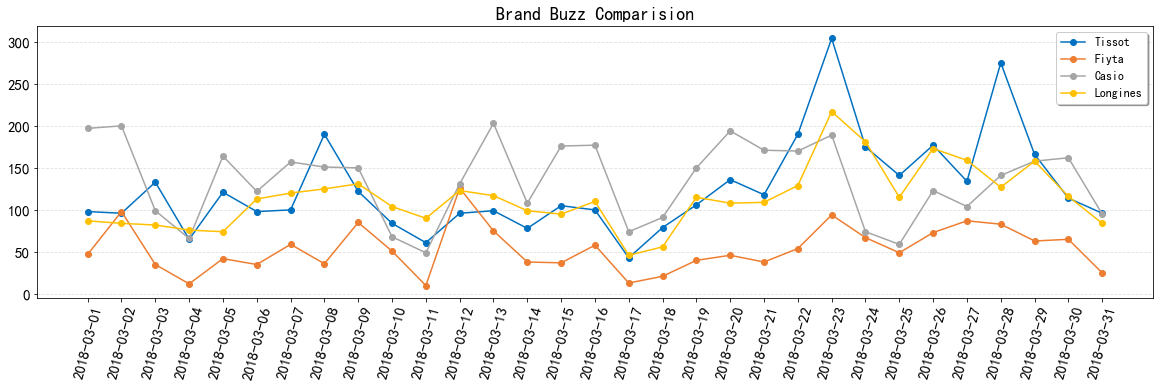

In [204]:

df_brand_buzz_pt=pd.pivot_table(df_brand_buzz, index=['ReleaseDate'],columns=['Brand'],values=['Buzz'])
display(df_brand_buzz_pt)

df_brand_buzz_pt=df_brand_buzz_pt.fillna(0)
df_brand_buzz_pt.columns = df_brand_buzz_pt.columns.levels[1]
df_brand_buzz_pt=df_brand_buzz_pt.reindex(columns=brand_index)
#display(df_brand_buzz_pt)
df_brand_buzz_pt=df_brand_buzz_pt.reset_index()
df_brand_buzz_plot=df_brand_buzz_pt.plot(kind="line",x='ReleaseDate',                   
                         #subplots =False,sharex=False,sharey=False, layout =(1,2),logx =True,stacked =True,marker='o',table=False,
                                         color=brand_colors,marker='o',
                          grid=False,figsize=(20,5),fontsize=font_size,use_index=False)
df_brand_buzz_plot.set_title("Brand Buzz Comparision",fontsize=title_fsize)
df_brand_buzz_plot.set_xticks(df_brand_buzz_pt.index)
df_brand_buzz_plot.set_xticklabels(df_brand_buzz_pt['ReleaseDate'],rotation=75)
df_brand_buzz_plot.yaxis.grid( linestyle='--', which='major',color='grey', alpha=.25)
plt.legend(frameon=True,shadow=True, loc='best');
#for i in df_brand_buzz_pt.index:
    #for col in new_columns_name:
        #plt.text( x=i, y= df_brand_buzz_pt.loc[i,col]+1,s=str( df_brand_buzz_pt.loc[i,col]),color="black",verticalalignment="baseline", horizontalalignment="center", size=10)


In [205]:
df_capturing_emotion=df_data_capturing[df_data_capturing['Type']=='常规'].groupby(['Brand','EmotionTag']).id.count().reset_index().rename(columns={'id':'Buzz','EmotionTag':'Item'})
df_capturing_type=df_data_capturing[df_data_capturing['Type']=='仿品类'].groupby(['Brand','Type']).id.count().reset_index().rename(columns={'id':'Buzz','Type':'Item'})
df_capturing_item=df_capturing_emotion.append(df_capturing_type).reset_index(drop=True)
df_capturing_item_pt=pd.pivot_table(df_capturing_item, index=['Item'],columns=['Brand'],values=['Buzz'])
df_capturing_item_pt.columns=df_capturing_item_pt.columns.levels[1]
df_capturing_item_pt=df_capturing_item_pt.reindex(columns=brand_index)
display(df_capturing_item_pt)

Brand,Tissot,Fiyta,Casio,Longines
Item,,,,
中性,1066,473,917,1152
仿品类,1876,145,843,3104
正面,2669,1156,1768,2144
负面,165,33,1488,227


In [212]:
import jieba
df_title= df_data_capturing[ (df_data_capturing['Type']=='常规') &(df_data_capturing['MediaType']=='新闻')  ]
df_title=df_title.groupby('Title')['id'].count().to_frame().rename(columns={'id':'Count'}).sort_values(by=['Count'],ascending=False)
#display(df_title)

,Count
Title,
消费升级名表行业持续复苏 飞亚达去年营收利润创新高,28
女子将20只手表绑腰间入关 箱内还有大量韩国衣帽,18
百大购物中心马鞍山路店-促销快讯,13
什么手表品牌好又不贵？,12
黄山百大商厦-促销快讯,12
"天猫超级粉丝日又来了,这次玩嗨的是天梭的粉丝们",9
成都：女子将20只手表捆绑藏匿腰间被海关挡获,8
郭富城亮相浪琴周年巡展 同台美女主持惹关注,7
飞亚达 (Fiyta) 腕表2018年巴塞尔世界钟表珠宝展新品前瞻,7
